In [1]:
colab_run = False
if colab_run:
    !pip install voxelmorph
    !pip install neurite
    !pip install git+https://github.com/voxelmorph/voxelmorph.git

In [2]:
model_loc = 'Models/'
csv_loc = 'CSV/'

In [3]:
# imports
import os, sys

# third party imports
import numpy as np
import tqdm
import pandas as pd
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

2023-01-25 11:27:18.742576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 11:27:19.655094: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/pravat/miniconda3/envs/tf/lib/
2023-01-25 11:27:19.655229: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/pravat/miniconda3/envs/tf/lib/
2023-01-25 11:27:19.655243: W tensorflow/compi

In [4]:
# Conform test data.
def conform(x, in_shape = (256,) * 2):
    '''Resize and normalize image.'''
    x = np.float32(x)
    x = ne.utils.minmax_norm(x)
    x = ne.utils.zoom(x, zoom_factor=[o / i for o, i in zip(in_shape, x.shape)])
    return np.expand_dims(x, axis=(0, -1))


In [5]:
def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [6]:
def vxm_data_generator_hybrid(x_data_real, x_data_synth, label_to_image, alpha_real=0.9, batch_size=1):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """    
    # preliminary sizing
    vol_shape = x_data_real.shape[1:] # extract data shape
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    batch_size_real = int(alpha_real*batch_size)
    batch_size_synth = batch_size - batch_size_real


    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1_real = np.random.randint(0, x_data_real.shape[0], size=batch_size_real)
        moving_images_real = x_data_real[idx1_real, ..., np.newaxis]
        idx2_real = np.random.randint(0, x_data_real.shape[0], size=batch_size_real)
        fixed_images_real = x_data_real[idx2_real, ..., np.newaxis]



        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1_synth = np.random.randint(0, x_data_synth.shape[0], size=batch_size_synth)
        moving_images_synth = x_data_synth[idx1_synth, ..., np.newaxis]
        idx2_synth = np.random.randint(0, x_data_synth.shape[0], size=batch_size_synth)
        fixed_images_synth = x_data_synth[idx2_synth, ..., np.newaxis]

        moving_images = np.concatenate([moving_images_real, label_to_image(moving_images_synth)], axis=0)
        fixed_images = np.concatenate([fixed_images_real, label_to_image(fixed_images_synth)], axis=0)

        inputs = [moving_images, fixed_images]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [7]:
def vxm_data_generator_real(x_data, batch_size=1):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

def vxm_data_generator_synth(x_data, label_to_image, batch_size=1):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = label_to_image(x_data[idx1, ..., np.newaxis])
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = label_to_image(x_data[idx2, ..., np.newaxis])
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [8]:
class SynthLabels():
    def __init__(self, num_label=16, num_maps=250):
        # Input shapes.
        self.in_shape = (256,) * 2
        self.num_dim = len(self.in_shape)
        self.num_label = num_label
        self.num_maps = num_maps
        gen_arg = dict(
            in_shape=self.in_shape,
            in_label_list=np.arange(16),
            warp_std=3,
            warp_res=(8, 16, 32),
        )
        self.gen_model = ne.models.labels_to_image(**gen_arg, id=1)

    def label_maps(self):
        # Shape generation.
        self.label_maps = []
        self.label_maps = np.zeros((self.num_maps, 256, 256))
        for i in tqdm.tqdm(range(self.num_maps)):
            # Draw image and warp.
            im = ne.utils.augment.draw_perlin(
                out_shape=(*self.in_shape, self.num_label),
                scales=(32, 64), max_std=1,
            )
            warp = ne.utils.augment.draw_perlin(
                out_shape=(*self.in_shape, self.num_label, self.num_dim),
                scales=(16, 32, 64), max_std=16,
            )
            # Transform and create label map.
            im = vxm.utils.transform(im, warp)
            lab = tf.argmax(im, axis=-1)
            self.label_maps[i] = np.uint8(lab)
        return self.label_maps
    
    def label_to_image(self, sample):
        return self.gen_model.predict(sample, verbose=0)[0]

2023-01-25 11:27:21.555791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 11:27:22.395334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15677 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


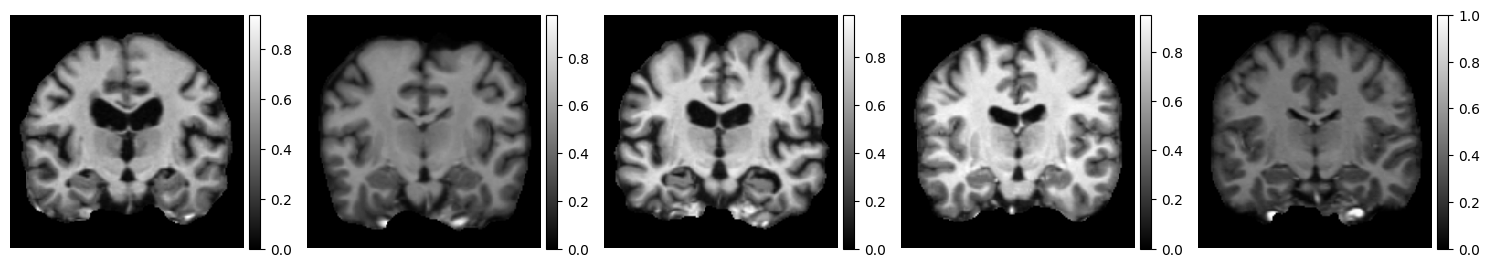

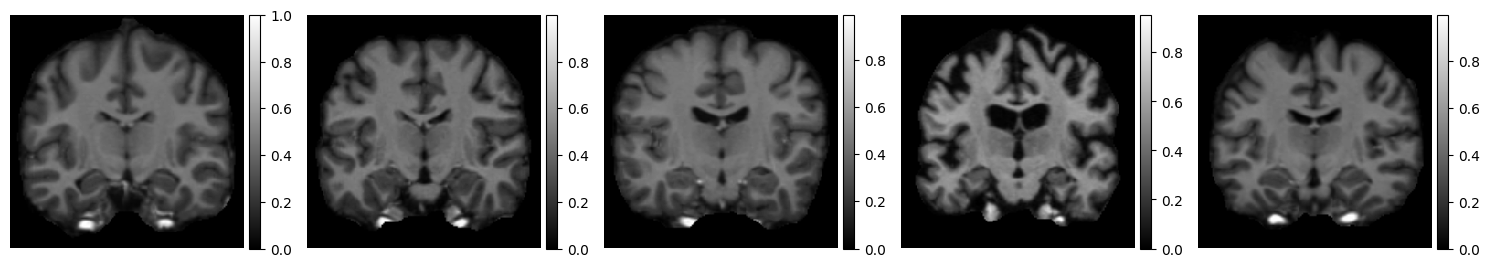

In [9]:
#Loading the dataset
images = ne.py.data.load_dataset('2D-OASIS-TUTORIAL')
conformed_images = [conform(img) for img in images]
#label_maps_real = [(img*15).astype('int').reshape(256, 256) for img in conformed_images]
label_maps_real = [img.reshape(256, 256) for img in conformed_images]


# Visualizing the dataset.
num_row = 2
per_row = 5
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(label_maps_real[i:i + per_row], cmaps=['gray'], do_colorbars=True)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


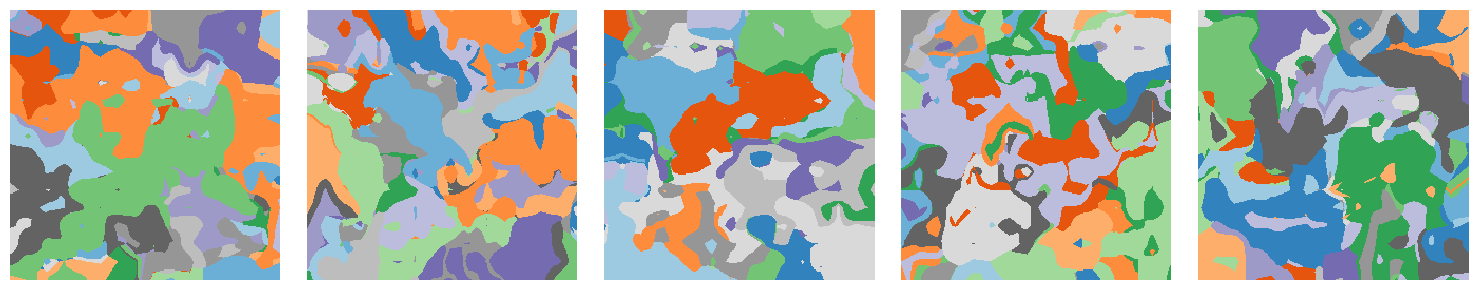

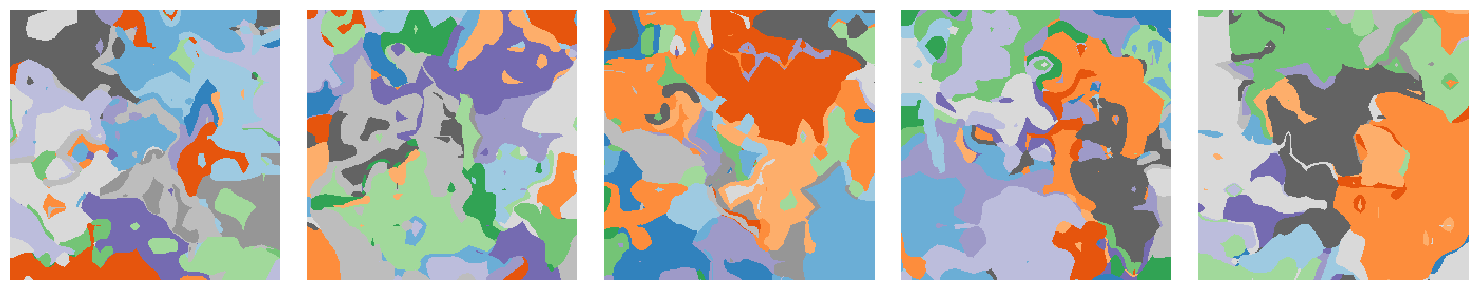

In [10]:
if os.path.exists('Synthetic_data.npy'):
    SynthIm = SynthLabels()
    label_maps_synth = np.load('Synthetic_data.npy')
    SynthIm.label_maps = label_maps_synth
else:
    SynthIm = SynthLabels()
    label_maps_synth = SynthIm.label_maps()
    np.save('Synthetic_data.npy', label_maps_synth)

# Visualize shapes.
num_row = 2
per_row = 5
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(list(label_maps_synth[i:i + per_row]), cmaps=['tab20c'])

In [11]:
class VxmTest():
    def __init__(self, ndim = 2, unet_input_features = 2):
        self.ndim = ndim
        self.unet_input_features = unet_input_features
    #CNN model
        # configure unet input shape (concatenation of moving and fixed images)
        self.vol_shape = real_train.shape[1:]
        # configure unet features 
        self.nb_features = [
            [16, 32, 32, 32],         # encoder features
            [32, 32, 32, 32, 32, 16, 16]  # decoder features
        ]
        
        
    def CNNvxm(self, train_gen=None, val_generator=None):
        self.vxm_model = vxm.networks.VxmDense(self.vol_shape, nb_unet_features=None, int_steps=0)
        self.losses = ['mse', vxm.losses.Grad('l2').loss]
        self.loss_weights = [1, 0.01]
        self.vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=self.losses, loss_weights=self.loss_weights)
        

        self.train_generator = train_gen
        self.val_generator = val_generator

        self.in_sample, self.out_sample = next(self.train_generator)
        def Visual():
            # visualize
            images = [img[0, :, :, 0] for img in self.in_sample + self.out_sample]
            titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
            ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);
        Visual()
        
    def train(self, total_epo, steps_per_epoch=100):
        self.hist = self.vxm_model.fit(self.train_generator, epochs=total_epo,
                                       steps_per_epoch=100, verbose=0,
                                       callbacks=[TqdmCallback(verbose=1)],
                                       validation_data=self.val_generator,
                                       validation_steps = 100);
        plot_history(self.hist)
        
    def RegPred(self, val_input):
        self.val_pred = self.vxm_model.predict(val_input)
        #visualise
        def Visual():
            images = [img[0, :, :, 0] for img in val_input + self.val_pred] 
            titles = ['moving', 'fixed', 'moved', 'flow']
            ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);
        Visual()
        return self.val_pred

In [12]:
#Fixing data + spliting

#conversion of labels in range of [0,1]
label_maps_real = np.array(label_maps_real)
label_maps_synth = np.array(label_maps_synth)
#label_maps_real = label_maps_real.astype('float')/15
#label_maps_synth = label_maps_synth.astype('float')/15
#label_maps_hy = np.zeros((250, 256, 256))
#label_maps_hy[::2] = [i for i in label_maps_real[:125, ...]]
#label_maps_hy[1::2] = [i for i in label_maps_synth[:125, ...]]
#label_maps_hy = np.array(label_maps_hy)

#data split 
Data_split_train = 250
real_train = label_maps_real[:250, ...]
# few_shot_train = label_maps_real[:50, ...]
test_val_no = 82
real_val = label_maps_real[250:332, ...]
real_test = label_maps_real[-82:, ...]

In [13]:
# if colab_run:
#     train_no = 100
#     batch_size = 8
# else:
#     train_no = 2000
#     batch_size = 32

In [14]:
train_no = 1500
no_of_rounds = 10
batch_size = 32

In [15]:
# # create the few shot data generator
# few_generator = vxm_data_generator_real(real_train, batch_size = batch_size)
# few_input, _ = next(few_generator)

# create the training data generator
train_generator = vxm_data_generator_real(real_train, batch_size = 1)
train_input, _ = next(train_generator)

# create the validation data generator
val_generator = vxm_data_generator_real(real_val, batch_size = 1)
val_input, _ = next(val_generator)

# create synthetic data generator
synth_generator = vxm_data_generator_synth(label_maps_synth, SynthIm.label_to_image, batch_size=1)
synth_input, _ = next(synth_generator)

#example of the hybrid data generator
# hybrid_generator = vxm_data_generator_hybrid(real_train, label_maps_synth, SynthIm.label_to_image, alpha_real=0.9, batch_size=batch_size)
# hybrid_input, _ = next(hybrid_generator)

2023-01-25 11:27:42.753449: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


In [16]:
# for i in range(50, 250, 50):
#     exec(f'few_shot_train_{i} = label_maps_real[:i, ...]')
# # create the few shot data generator
#     exec(f'few_generator_{i} = vxm_data_generator_real(few_shot_train_{i}, batch_size =1)')
#     exec(f'few_input_{i}, _ = next(few_generator_{i})')

In [17]:
def plot_csv(filename):
    df = pd.read_csv(filename)
    nu = df.to_numpy()
    fh = nu.size
    plt.figure()
    plt.plot(range(1,nu.size+1), nu, '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [18]:
# Synth = VxmTest()
# Synth.CNNvxm(train_gen=synth_generator, val_generator=val_generator)
# Synth.train(total_epo=train_no)
# Synth.vxm_model.save_weights(model_loc+'Synth_fewshot.h5')
# b = Synth.hist.history['loss']
# df = pd.DataFrame(b )
# df.to_csv(csv_loc+'Synth_loss_fewshot.csv', index=False, header=False)
# for i in range(no_of_rounds-1):
#     Synth.vxm_model.load_weights(model_loc+'Synth_fewshot.h5')
#     Synth.train(total_epo=train_no)
#     Synth.vxm_model.save_weights(model_loc+'Synth_fewshot.h5')
#     b = Synth.hist.history['loss']
#     df = pd.DataFrame(b)
#     df.to_csv(csv_loc+'Synth_loss_fewshot.csv', index=False, mode='a', header=False)

In [19]:
# plot_csv(csv_loc + 'Synth_loss_fewshot.csv')

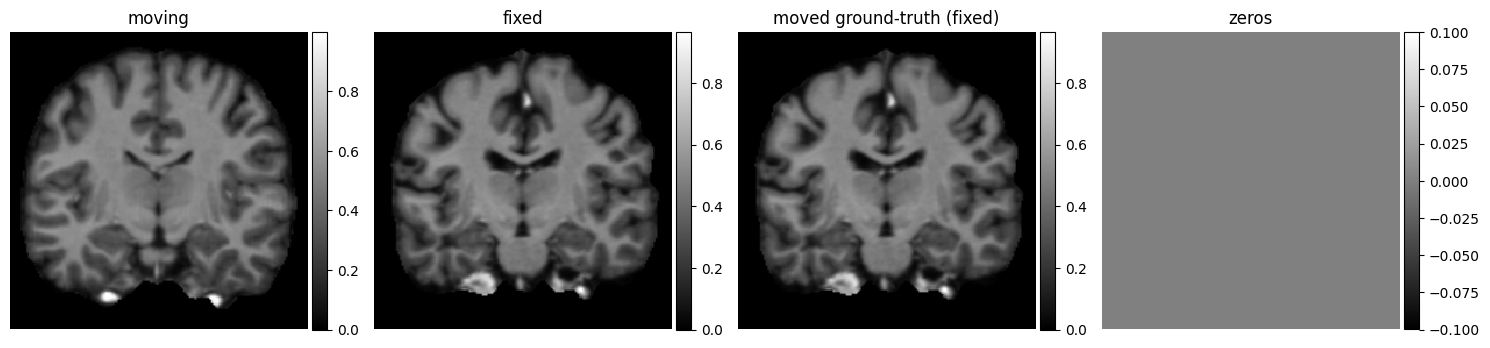

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-01-25 11:27:49.622466: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f283ea45dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-25 11:27:49.622531: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-01-25 11:27:49.632030: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-25 11:27:50.017723: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


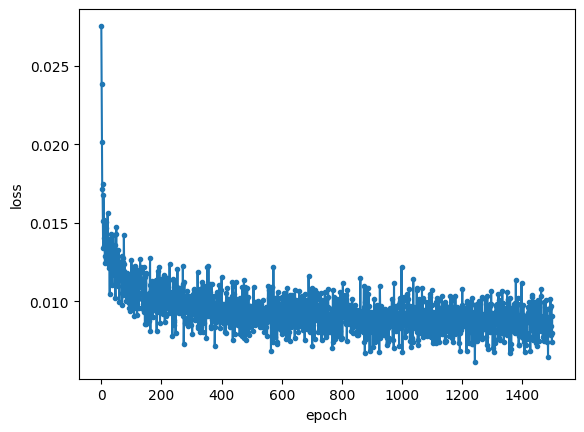

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

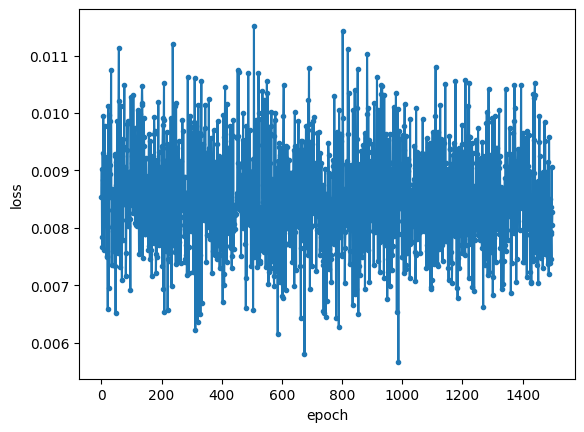

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

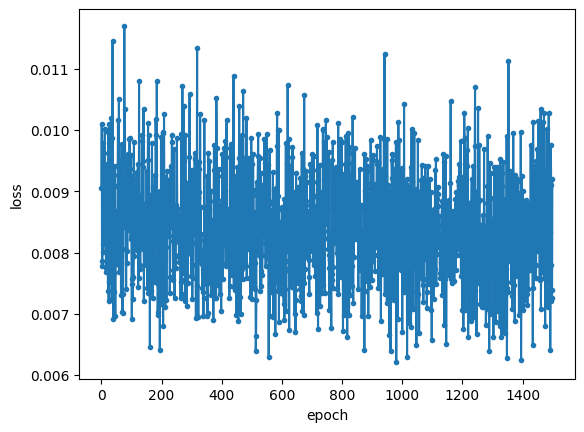

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

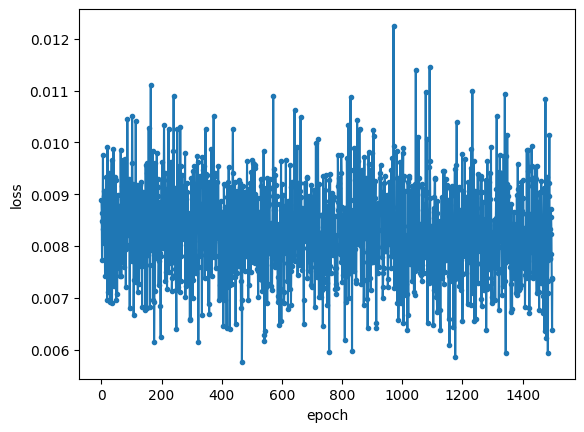

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

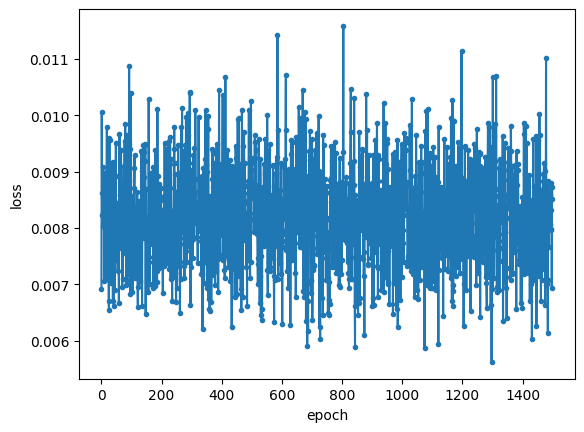

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

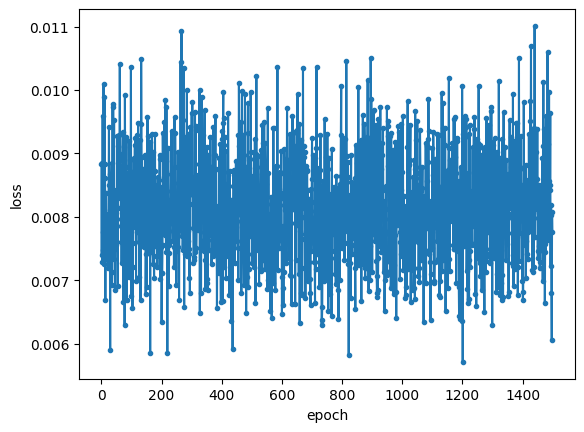

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

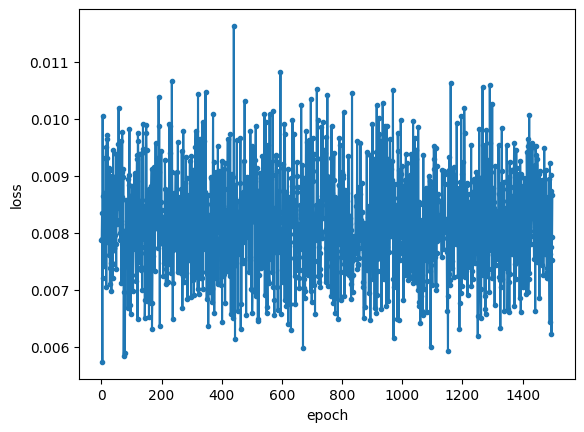

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

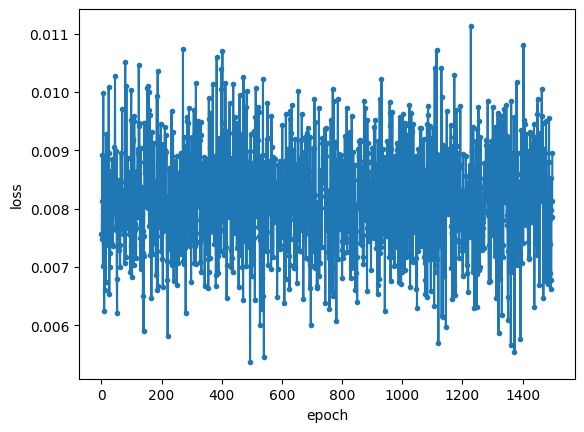

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

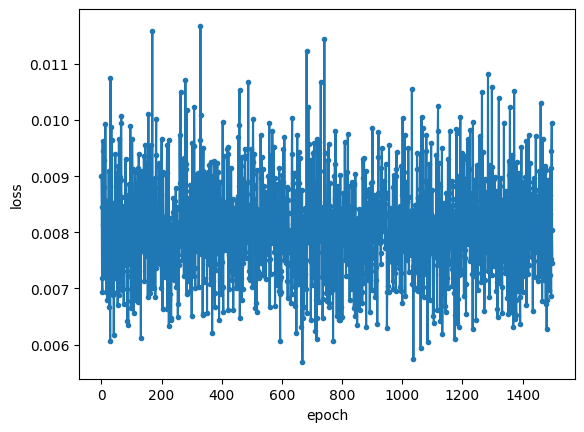

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

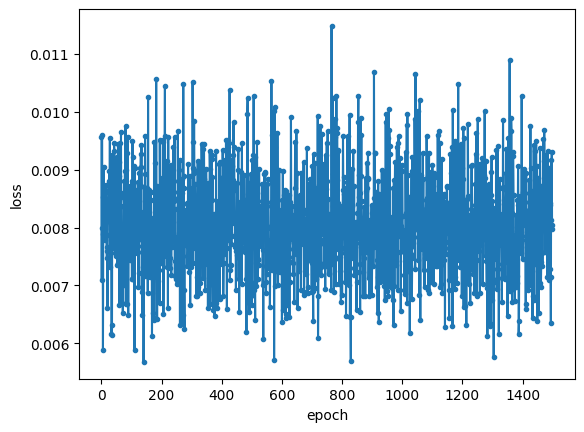

In [20]:
Real = VxmTest()
Real.CNNvxm(train_gen=train_generator, val_generator=val_generator)
Real.train(total_epo=train_no)
Real.vxm_model.save_weights(model_loc+'Real.h5')
b = Real.hist.history['loss']
df = pd.DataFrame(b)
df.to_csv(csv_loc+'Real_100step_loss.csv', index=False, header=False)
for i in range(no_of_rounds-1):
    Real.vxm_model.load_weights(model_loc+'Real.h5')
    Real.train(total_epo=train_no)
    Real.vxm_model.save_weights(model_loc+'Real.h5')
    b = Real.hist.history['loss']
    df = pd.DataFrame(b)
    df.to_csv(csv_loc+'Real_100step_loss.csv', index=False, mode='a', header=False)

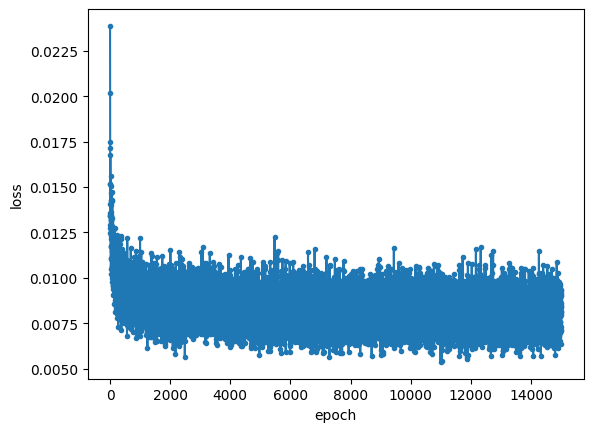

In [21]:
plot_csv(csv_loc+'Real_100step_loss.csv')

In [22]:
# goblin = '.h5'
# goblin_csv = '.csv'
# name = 'Fshot_Real_'
# led = 'loss'
# mode_csv = 'a'
# name_loss = 'Fshot_Real_Loss_'

In [23]:
# #Few shots training
# for k in range(50, 250, 50):
#     exec(f'Fshot_{k} = VxmTest()')
#     exec(f'Fshot_{k}.CNNvxm(train_gen=few_generator_{k}, val_generator=val_generator)')
#     exec(f'Fshot_{k}.train(total_epo = train_no)')
#     exec(f'loc = model_loc+name+str({k})+goblin')
#     exec(f'Fshot_{k}.vxm_model.save_weights(model_loc+name+str({k})+goblin)')
#     exec(f'b = Fshot_{k}.hist.history[led]')
#     exec(f'df = pd.DataFrame(b)')
#     exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
#     exec(f'df.to_csv(loc, index=False, header=False)')
#     for i in range(no_of_rounds-1):
#         exec(f'Fshot_{k}.vxm_model.load_weights(model_loc+name+str({k})+goblin)')
#         exec(f'Fshot_{k}.train(total_epo = train_no)')
#         exec(f'Fshot_{k}.vxm_model.save_weights(model_loc+name+str({k})+goblin)')
#         exec(f'b = Fshot_{k}.hist.history[led]')
#         exec(f'df = pd.DataFrame(b)')
#         exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
#         exec(f'df.to_csv(loc, mode = mode_csv, index=False, header=False)')

#     exec(f'fshot_{k} = Fshot_{k}.RegPred(val_input)[1]')

In [24]:
# for k in range(50, 250, 50):
#     exec(f'loc = csv_loc+name_loss+str({k})+goblin_csv')
#     exec(f'plot_csv(loc)')

1/1 [==============================] - 1s 719ms/step


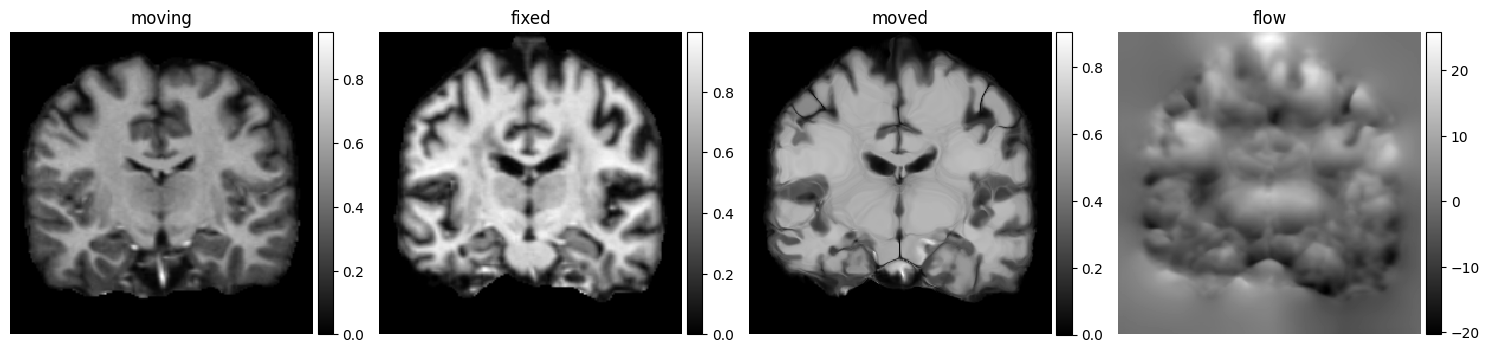

In [25]:
real = Real.RegPred(val_input)[1]
# synth = Synth.RegPred(val_input)[1]

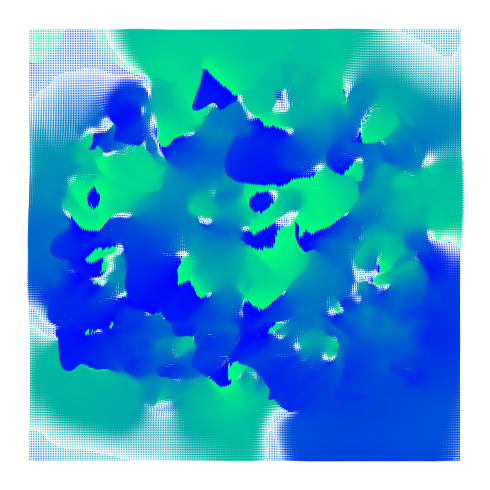

In [26]:
ne.plot.flow([real[0].squeeze()], width=5);
# ne.plot.flow([synth[0].squeeze()], width=5);

In [27]:
# for k in range(50, 250, 50):
#     exec(f'ne.plot.flow([fshot_{k}[0].squeeze()],titles=k, width=5);')